# Demo

In [1]:
import skimage
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters
from pathlib import Path
import scipy.ndimage as ndi
import pandas as pd

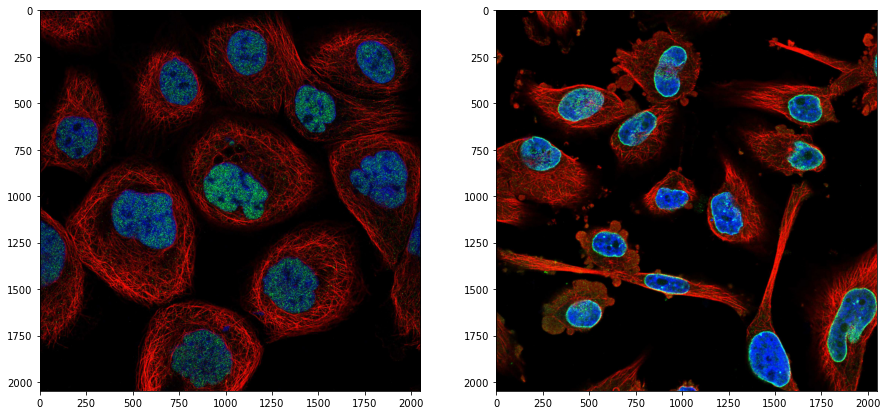

In [2]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/cellatlas/images/24138_196_F7_2.tif'))
ax[1].imshow(skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/cellatlas/images/27897_273_C8_2.tif'));

In [ ]:
channel_nuclei = 2
channe_signal = 1

ratios = []

for f in Path('images/').glob('*.tif'):
    # import image
    image = skimage.io.imread(f)
    
    # filter the nuclei image
    im_filtered = skimage.filters.median(image[:,:,channel_nuclei], skimage.morphology.disk(5))
    
    # threshold
    th = skimage.filters.threshold_otsu(im_filtered)
    nucl_th = im_filtered > th
    
    # clean-up
    nucl_close = skimage.morphology.binary_closing(nucl_th, selem=skimage.morphology.disk(5))
    nucl_fill = ndi.binary_fill_holes(nucl_close, skimage.morphology.disk(5))
    
    # create band around nuclei
    eroded = skimage.morphology.binary_erosion(nucl_fill, selem=skimage.morphology.disk(10))
    edge = np.logical_and(nucl_fill, np.logical_not(eroded))
    
    # label and measure
    im_lab = skimage.morphology.label(nucl_fill)
    measure_eroded = skimage.measure.regionprops_table(im_lab * eroded, image[:,:,channe_signal],
                                                       properties=('label', 'mean_intensity', 'area'))
    measure_edge = skimage.measure.regionprops_table(im_lab * edge, image[:,:,channe_signal],
                                                     properties=('label', 'mean_intensity', 'area'))
    
    # calculate ratios and filter by size
    edge_dict = {}
    for i in range(len(measure_edge['label'])):
        if measure_edge['area'][i] > 100:
            edge_dict[measure_edge['label'][i]] = measure_edge['mean_intensity'][i]
    image_ratio = []
    for i in range(len(measure_eroded['label'])):
        temp_ratio = measure_eroded['mean_intensity'][i] / edge_dict[measure_eroded['label'][i]]
        image_ratio.append(temp_ratio)
    ratios.append(np.mean(image_ratio))
    
    '''
    ## More elegant solution with Pandas df
    # turn results into dataframes
    measure_eroded_df = pd.DataFrame(measure_eroded)
    measure_edge_df = pd.DataFrame(measure_edge)
    
    # combined nuclei and band measures and compute intensity ratio mean
    merged = pd.merge(measure_eroded_df, measure_edge_df, on='label', how='inner')
    merged['ratio'] = merged['mean_intensity_x']/merged['mean_intensity_y']
    
    # add to final list
    ratios.append(merged.mean()['ratio'])
    '''
ratios = np.array(ratios)

# get name of all files
all_files = np.array([a.name for a in Path('images/').glob('*.tif')])

# select high- and low-ratio images
high_ratio = all_files[np.array(ratios)>1]
low_ratio = all_files[np.array(ratios)<1]

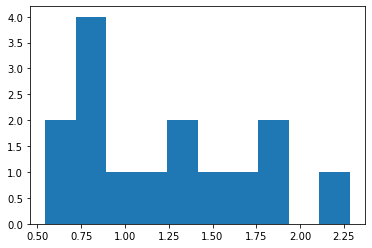

In [5]:
plt.hist(ratios);

## Import image

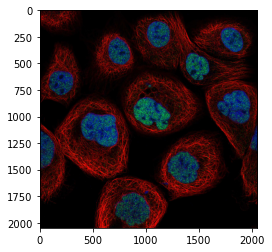

In [10]:
image = skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/cellatlas/images/24138_196_F7_2.tif')
plt.imshow(image);

## Filter the image

In [11]:
im_filtered = skimage.filters.median(image[:,:,2], skimage.morphology.disk(5))

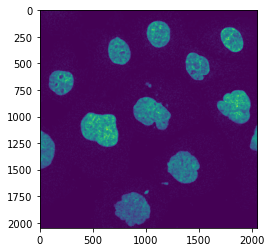

In [12]:
plt.imshow(im_filtered);

## Automated threshold

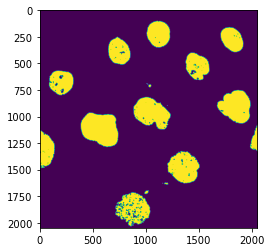

In [13]:
th = skimage.filters.threshold_otsu(im_filtered)
nucl_th = im_filtered > th
plt.imshow(nucl_th);

## Clean-up with morphological operations

In [14]:
nucl_close = skimage.morphology.binary_closing(nucl_th, selem=skimage.morphology.disk(5))
nucl_fill = ndi.binary_fill_holes(nucl_close, skimage.morphology.disk(5))

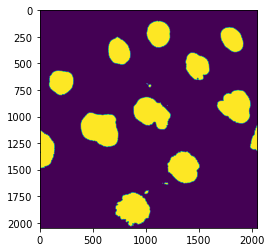

In [15]:
plt.imshow(nucl_fill);

## Compute a band around the nuclei

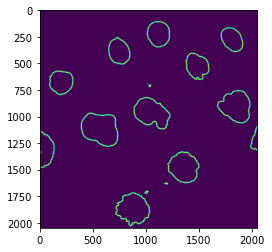

In [16]:
eroded = skimage.morphology.binary_erosion(nucl_fill, selem=skimage.morphology.disk(10))
edge = np.logical_and(nucl_fill, np.logical_not(eroded))

plt.imshow(edge);

## Label nuclei and band and measure properties

In [17]:
im_lab = skimage.morphology.label(nucl_fill)
measure_eroded = skimage.measure.regionprops_table(im_lab * eroded, image[:,:,1], properties=('label', 'mean_intensity', 'area'))
measure_edge = skimage.measure.regionprops_table(im_lab * edge, image[:,:,1], properties=('label', 'mean_intensity', 'area'))

## Post-processing: stats 

This step can be done "manually" using list, dictionaries etc. or in a more efficient way using Pandas dataframes.

In [18]:
edge_dict = {}
for i in range(len(measure_edge['label'])):
    if measure_edge['area'][i] > 100:
        edge_dict[measure_edge['label'][i]] = measure_edge['mean_intensity'][i]
image_ratio = []
for i in range(len(measure_eroded['label'])):
    temp_ratio = measure_eroded['mean_intensity'][i] / edge_dict[measure_eroded['label'][i]]
    image_ratio.append(temp_ratio)
mean_val  = np.mean(image_ratio)
mean_val

1.633106405481683

or

In [47]:
import pandas as pd
measure_eroded_df = pd.DataFrame(measure_eroded)
measure_edge_df = pd.DataFrame(measure_edge)

In [48]:
merged = pd.merge(measure_eroded_df, measure_edge_df, on='label', how='inner')
merged['ratio'] = merged['mean_intensity_x']/merged['mean_intensity_y']

In [49]:
mean_val = merged.mean()['ratio']
mean_val

1.633106405481683